## Load Libs

In [22]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
sns.set(style="white")

%matplotlib inline

def heatmap(data, *cols, target, xtick=None, ytick=None, annot=True, fmt='.2f', figsize=None):
    import seaborn as sns
    from matplotlib import pyplot as plt

    figsize = figsize or (16, 4)
    f, axs = plt.subplots(1, 2, figsize=figsize)

    def draw(chop, axis):
        pivot_params = list(cols) + [target]
        g = chop.groupby(list(cols))[target]
        mean_ = g.mean().reset_index().pivot(*pivot_params)
        count_ = g.size().reset_index().pivot(*pivot_params)
        if xtick is not None or ytick is not None:
            mean_ = mean_.reindex(index=ytick, columns=xtick)
            count_ = count_.reindex(index=ytick, columns=xtick)

        sns.heatmap(mean_.fillna(0), annot=annot, ax=axis[0], fmt=fmt, cmap="YlGnBu")
        sns.heatmap(count_.fillna(0), annot=annot, ax=axis[1], fmt=fmt, cmap="YlGnBu")
        axis[0].set_title('mean')
        axis[1].set_title('count')

    draw(data, axs)
    plt.show()
    
def chi_square(x, y, data, verbose=True):
    """
    Return: True if x is dependet with y else False
    """
    table = data.groupby([x, y]).size().reset_index(name='size')
    pivot = table.pivot(index=x, columns=y, values='size').fillna(0.)
    
    # Calculate chi-square value, p-value, degree of freedom, expected value
    chi, pv, df, expected = stats.chi2_contingency(observed=pivot.values)
    # check if chi-square value > criterion(95% confidence interval)
    crit = stats.chi2.ppf(q=0.95, df=df)
    if verbose:
        print(pivot)
        print()
        print(expected)
        print()
        print(f'chi-square value: {chi}, criterion: {crit}')
    return chi > crit

def anova(formula, data, verbose=True):
    table  = sm.stats.anova_lm(
        ols(formula, data=data).fit(), 
        typ=2)
    return table

Requirement already up-to-date: seaborn in d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages (0.9.0)


# Purpose: 
* 給定金融客戶Metadata, 繳費行為等等, 預測該客戶是否在未來有可能離開?

## Data Schema

Column name     | Description
             ---|---
RorNumber       |    Row number
CustomerId      |    Customer id
Surname         |    Customer surname
CreditScore     |    Credit score
Geography       |    Country the customer belong to
Gender          |    Female or Male
Age             |    Customer's age
Tenure          |    Life length of customer
Balance         |    Bank balance of the customer
NumOfProducts   |    Number of product belong to the customer
HasCrCard       |    If customer has credit card
IsActiveMember  |    If customer status is active or disabled
EstimatedSalary |    Estimated salary for the customer
Claim          |    Label, 1: Claim, 0: Not Claim

---

* 7個類別變數
* 6個數值變數
---



# Data Preview


---



In [23]:
raw = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_insurance_claim.csv")
raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Claim
0,6396,15707918,Bentley,741,Germany,Female,36,0,127675.39,2,1,0,74260.16,0
1,6055,15773013,Uvarov,633,France,Female,47,0,0.00,1,1,1,6342.84,1
2,8866,15639004,Chiemezie,668,France,Male,72,2,0.00,2,1,1,70783.61,0
3,9098,15606901,Graham,728,France,Male,43,7,0.00,2,1,0,40023.70,0
4,3865,15808960,Alleyne,620,Germany,Male,40,5,108197.11,2,1,0,49722.34,0


## Drop 不必要的欄位

In [24]:
raw.drop(['RowNumber', 'CustomerId', 'Surname'], 1, inplace=True)

In [25]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
CreditScore        7500 non-null int64
Geography          7500 non-null object
Gender             7500 non-null object
Age                7500 non-null int64
Tenure             7500 non-null int64
Balance            7500 non-null float64
NumOfProducts      7500 non-null int64
HasCrCard          7500 non-null int64
IsActiveMember     7500 non-null int64
EstimatedSalary    7500 non-null float64
Claim              7500 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 644.6+ KB


# Feature Settings

In [26]:
catg_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
label = 'Claim'
print(f'Categorical: {catg_features}')
print(f'Numerical: {num_features}')

Categorical: ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
Numerical: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


0    3.844961
1    1.000000
Name: Claim, dtype: float64



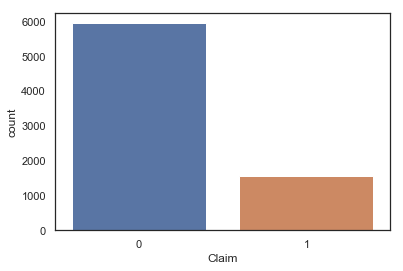

In [27]:
v_cnt = raw.Claim.value_counts()
print(v_cnt / v_cnt[1])
print()

sns.countplot(data=raw, x='Claim')
plt.show()

## Observation

* Not Churn : Churn 的數量大約是 1 : 4 左右

---

<br/>
<br/>
<br/>



---

# 單變數分析: Numeric Features

## Age: Distribution Plot, Box Plot, ANOVA

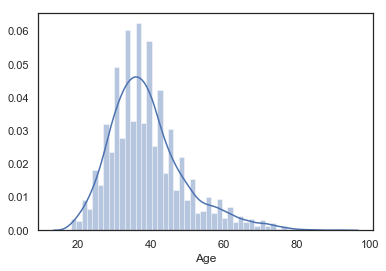

In [28]:
sns.distplot(raw.Age)

In [29]:
raw.Age.describe()

count    7500.000000
mean       39.004267
std        10.500007
min        18.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        92.000000
Name: Age, dtype: float64

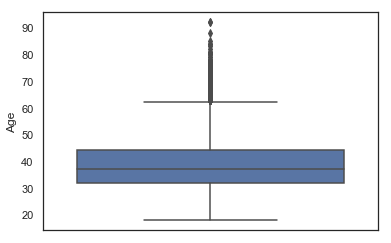

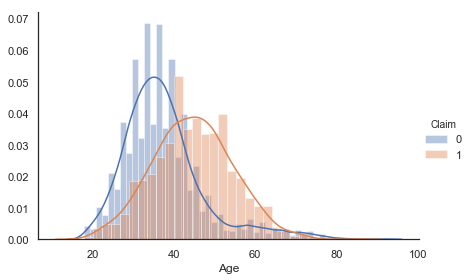

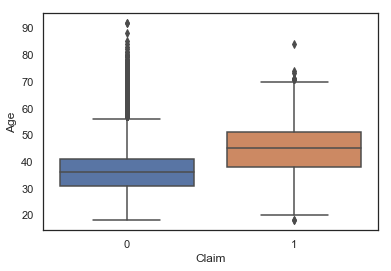

In [30]:
sns.boxplot(raw.Age, orient='v')
plt.show()

g = sns.FacetGrid(data=raw, hue='Claim', height=4, aspect=1.5)
g.map(sns.distplot, 'Age').add_legend()
plt.show()

sns.boxplot(x='Claim', y='Age', data=raw)
plt.show()

In [31]:
anova("Age ~ C(Claim)", data=raw)

,sum_sq,df,F,PR(>F)
C(Claim),63991.391600,1.0,629.02925,2.266897e-133
Residual,762774.471867,7498.0,NaN,NaN


### 切割`Age`為類別變數(AgeBin)

* 觀察Age的資料分布 (quantile median, min, max), 決定切割方式

In [32]:
age_stats = raw.Age.describe()

# IQR: interquartile range
iqr = age_stats['75%'] - age_stats['25%']
l_bound = age_stats['25%'] - iqr * 1.5
u_bound = age_stats['75%'] + iqr * 1.5

print(f'Lower bound = {l_bound}')
print(f'Upper bound = {u_bound}')

Lower bound = 14.0
Upper bound = 62.0


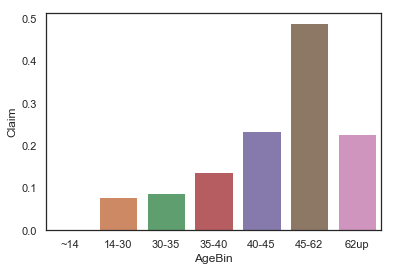

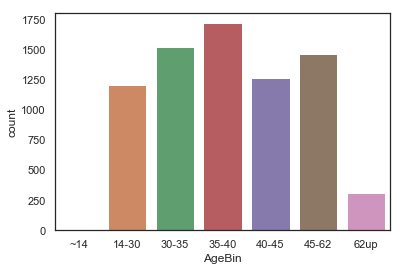

In [33]:
bins = np.array([14, 30, 35, 40, 45, 62])

labels = ['~14', '14-30', '30-35', '35-40', '40-45', '45-62', '62up']
age_map = pd.Series(labels)
raw['AgeBin'] = pd.Series(np.digitize(raw.Age, bins)).map(age_map)

sns.barplot(x="AgeBin", y='Claim', data=raw, ci=None, order=labels)
plt.show()

sns.countplot(x="AgeBin", data=raw, order=labels)
plt.show()

In [34]:
result = chi_square(x='AgeBin', y='Claim', data=raw)
print(f'result: {result}')

Claim      0    1
AgeBin           
14-30   1115   94
30-35   1391  134
35-40   1484  237
40-45    971  296
45-62    749  716
62up     242   71

[[ 959.4624  249.5376]
 [1210.24    314.76  ]
 [1365.7856  355.2144]
 [1005.4912  261.5088]
 [1162.624   302.376 ]
 [ 248.3968   64.6032]]

chi-square value: 1022.0252914405212, criterion: 11.070497693516351
result: True


## Balance: Distribution Plot, Violin Plot, ANOVA

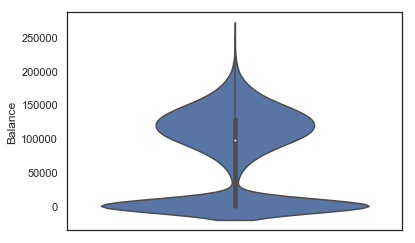

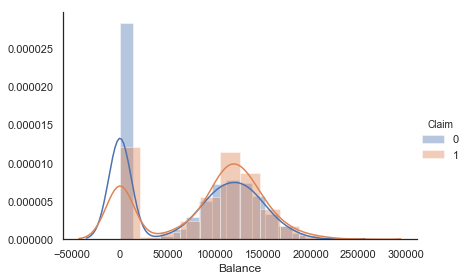

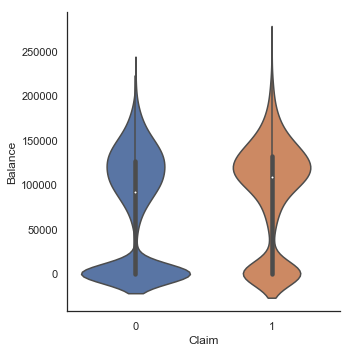

In [35]:
sns.violinplot(raw.Balance, orient='v')
plt.show()

g = sns.FacetGrid(data=raw, hue='Claim', height=4, aspect=1.5)
g.map(sns.distplot, 'Balance').add_legend()
plt.show()

sns.catplot(x='Claim',
            y='Balance', 
            kind='violin', data=raw)
plt.show()

In [36]:
anova('Balance ~ C(Claim)', data=raw)

,sum_sq,df,F,PR(>F)
C(Claim),3.861981e+11,1.0,100.085983,2.045329e-23
Residual,2.893226e+13,7498.0,NaN,NaN


### 觀察Balance Feature Line Plot

count      7500.000000
mean      76472.102569
std       62527.184934
min           0.000000
25%           0.000000
50%       97055.145000
75%      127811.165000
max      250898.090000
Name: Balance, dtype: float64


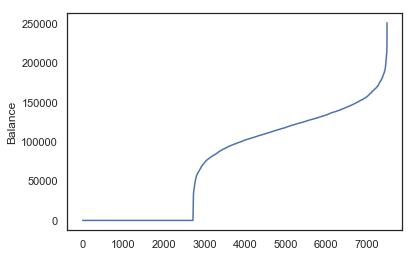

In [37]:
print( raw.Balance.describe() )

ax = sns.lineplot(x=range(len(raw)), y=raw.Balance.sort_values())
plt.show()

### 切割Balance Feature為類別變數 (HasBalance)

-  新增 `HasBalance` feature: 是否 `Balance` 為 0

In [38]:
raw['HasBalance'] = (raw.Balance > 0).astype(int)

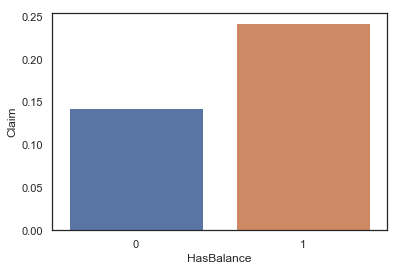

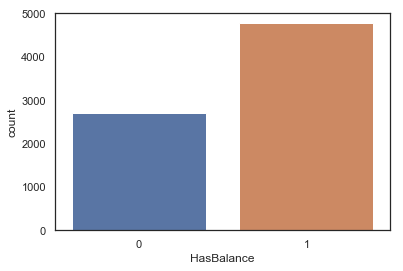

In [39]:
sns.barplot(x='HasBalance', y='Claim', data=raw, ci=None)
plt.show()

sns.countplot(x='HasBalance', data=raw)
plt.show()

In [40]:
result = chi_square(x='HasBalance', y='Claim', data=raw)
print(f'result: {result}')

Claim          0     1
HasBalance            
0           2329   390
1           3623  1158

[[2157.7984  561.2016]
 [3794.2016  986.7984]]

chi-square value: 102.63539158759608, criterion: 3.841458820694124
result: True


## (LAB) Tenure(租期): Distribution Plot, Box Plot, ANOVA

In [41]:
# 解開註解並且修改問號的部分
# sns.boxplot(???, orient='v')
# plt.show()

# g = sns.FacetGrid(data=raw, hue='Claim', height=4, aspect=1.5)
# g.map(sns.distplot, ???).add_legend()
# plt.show()

# sns.boxplot(x='Claim', y=???, data=raw)
# plt.show()

In [42]:
# 寫出ANOVA formula => ??? ~ C(???)
# anova("???", data=raw)

## (LAB) CreditScore: Distribution Plot, Violin Plot, ANOVA

In [43]:
# 解開註解並且修改問號的部分
# sns.violinplot(???, orient='v')
# plt.show()

# g = sns.FacetGrid(data=raw, hue='Claim', height=4, aspect=1.5)
# g.map(sns.distplot, ???).add_legend()

# sns.boxplot(x='Claim', y=???, data=raw)
# plt.show()

In [44]:
# 寫出ANOVA formula => ??? ~ C(???)
# anova("???", data=raw)

## (LAB) NumOfProducts: Distribution Plot, Violin Plot, ANOVA

In [45]:
# Violin Plot

# Distplot

# Violin Plot, hue='Claim'


In [46]:
# ANOVA


## Observation

- `Claim = 0` 的人沒有NumOfProduct > 2的資料
- `NumOfProducts = 2` 退租率特別低
- `NumOfProducts = 3,4`有極高的退租率 (但是觀察資料數量太少)

## (LAB) EstimatedSalary(財力證明): Distribution Plot, ANOVA

In [47]:
# Distplot

# Distplot, hue='Claim'

## (LAB) EstimatedSalary: 四分位數, Line Plot(不須做切割)

In [48]:
# Lineplot


## Observation

* `Tenure` 的分布在`Claim` = 0 or 1都沒有顯著差異
* `CreditScore` 的分布在Claim = 0 or 1都沒有顯著差異
* `EstimatedSalary` 的分布在Claim = 0 or 1都沒有顯著差異

---

* `Balance`的分布在`Claim` = 0, 1 有些微的顯著差異
* `Age` 分布在`Claim` = 0, 1 有些微的顯著差異
* `NumOfProduct`:
    - `Claim = 0` 的人沒有NumOfProduct > 2的資料
    - `NumOfProduct = 2` 退租率特別低

---

<br/>
<br/>
<br/>



---


# 單變數分析: Categorical Features

## Geography: Bar Chart (Mean + Count)

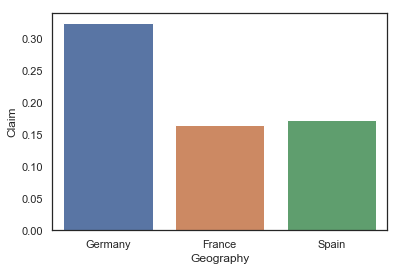

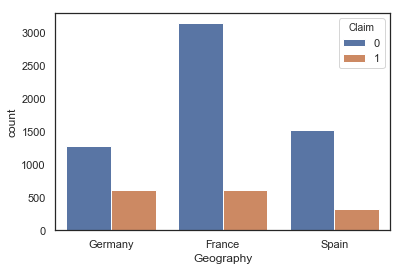

In [49]:
sns.barplot(x='Geography', y='Claim', data=raw, ci=None)
plt.show()

sns.countplot(x='Geography', hue='Claim', data=raw)
plt.show()

### Geography x Claim: Chi Square Test of Independence

In [50]:
result = chi_square(x='Geography', y='Claim', data=raw)
print(f'result: {result}')

Claim         0    1
Geography           
France     3140  616
Germany    1285  615
Spain      1527  317

[[2980.7616  775.2384]
 [1507.84    392.16  ]
 [1463.3984  380.6016]]

chi-square value: 214.16690139147732, criterion: 5.991464547107979
result: True


## Gender: Bar Chart (Mean + Count)

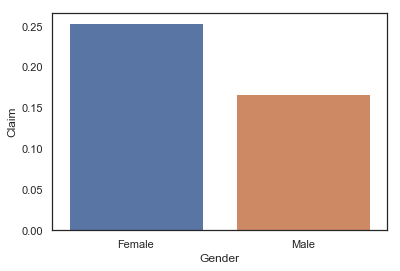

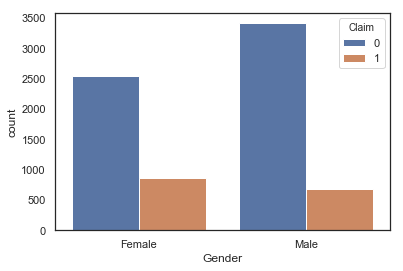

In [51]:
sns.barplot(x='Gender', y='Claim', data=raw, ci=None)
plt.show()

sns.countplot(x='Gender', hue='Claim', data=raw)
plt.show()

### Gender x Claim: Chi Square Test of Independence

In [52]:
result = chi_square(x='Gender', y='Claim', data=raw)
print(f'result: {result}')

Claim      0    1
Gender           
Female  2541  864
Male    3411  684

[[2702.208  702.792]
 [3249.792  845.208]]

chi-square value: 84.81133153429565, criterion: 3.841458820694124
result: True


## Observation

* `Geography = France` 人口最多
* `Geography = Germany` 人口最少, **相對其他類別**退租率較高 (也只有0.3)
* `Geography` 是顯著的feature
* `Gender` 是顯著的feature


---



## (LAB) HasCrCard: Bar Chart (Mean + Count)

In [53]:
# 解開註解並且, 修改問號部分
# sns.barplot(x='???', y='Claim', data=raw, ci=None)
# plt.show()

# sns.countplot(x='???', hue='Claim', data=raw)
# plt.show()

### (LAB) HasCrCard x Claim: Chi Square Test of Independence

In [54]:
# 解開註解並且, 修改問號部分
# result = chi_square(x='???', y='Claim', data=raw)
# print(f'result: {result}')

## (LAB) IsActiveMember: Bar Chart (Mean + Count)

In [55]:
# Barplot

# Countplot

### (LAB) IsActiveMemeber x Claim: Chi Square Test of Independence

In [56]:
# Call Chi-Square function and print result


## (LAB) NumOfProducts: Bar Chart (Mean + Count)

In [57]:
# Barplot

# Countplot

### (LAB) NumOfProducts x Claim: Chi Square Test of Independence

In [58]:
# Call Chi-Square function and print result


## Observation

* `HasCrCard` 不顯著
* `Gender = Male` 的退租率會稍微低一點, 是顯著Feature
* `IsActiveMember` = 1的退租率會稍微低一點, 是顯著Feature
* `NumOfProducts`: 是顯著Feature

---

<br/>
<br/>
<br/>

# 多變數分析: Categorical x Categorical

* heatmap
* bar chart: count, mean
---


## Geography x Gender: Heatmap

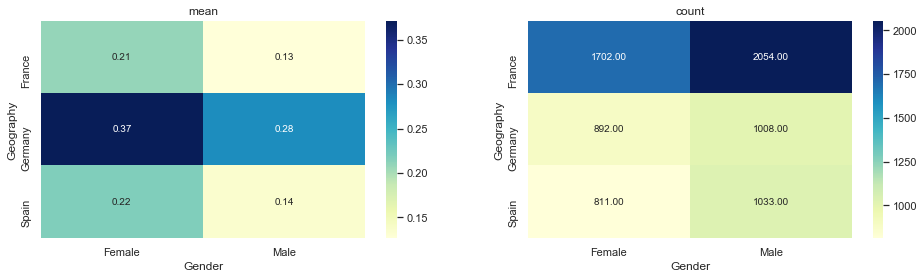

In [59]:
heatmap(raw, 'Geography', 'Gender', target='Claim')

### Geography x Gender: Chi Square Test of Independence

In [60]:
result = chi_square(x='Geography', y='Gender', data=raw)
print(f'result: {result}')

Gender     Female  Male
Geography              
France       1702  2054
Germany       892  1008
Spain         811  1033

[[1705.224 2050.776]
 [ 862.6   1037.4  ]
 [ 837.176 1006.824]]

chi-square value: 3.345387158056994, criterion: 5.991464547107979
result: False


## AgeBin x Gender: Heatmap

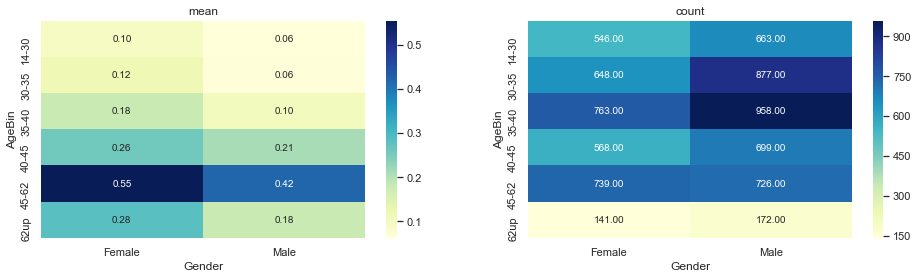

In [61]:
heatmap(raw, 'AgeBin', 'Gender', target='Claim')

### AgeBin x Gender: Chi Square Test of Independence

In [62]:
result = chi_square(x='AgeBin', y='Gender', data=raw)
print(f'result: {result}')

Gender  Female  Male
AgeBin              
14-30      546   663
30-35      648   877
35-40      763   958
40-45      568   699
45-62      739   726
62up       141   172

[[548.886 660.114]
 [692.35  832.65 ]
 [781.334 939.666]
 [575.218 691.782]
 [665.11  799.89 ]
 [142.102 170.898]]

chi-square value: 21.234804823045156, criterion: 11.070497693516351
result: True


## (LAB)  Geography x HasCrCard: Heatmap

In [63]:
# 解開註解並且修改問號部分
# heatmap(raw, '???', '???', target='Claim')

### (LAB) Geography x HasCrCard: Chi Square Test of Independence

In [64]:
# Call Chi-Square function and print result


## (LAB) Geography x IsActiveMember: Heatmap

In [65]:
# Draw heatmap By calling function "heatmap"


### (LAB) Geography x IsActiveMember: Chi Square Test of Independence

In [66]:
# Call Chi-Square function and print result


## (LAB) HasBalance x IsActiveMember: Heatmap

In [67]:
# Draw heatmap By calling function "heatmap"


### (LAB) HasBalance x IsActiveMember: Chi Square Test of Independence

In [68]:
# Call Chi-Square function and print result


## (LAB) AgeBin x Geography: Heatmap

In [69]:
# Draw heatmap By calling function "heatmap"


### (LAB) AgeBin x Geography: Chi Square Test of Independence

In [70]:
# Call Chi-Square function and print result


## (LAB) AgeBin x IsActiveMember: Heatmap

In [71]:
# Draw heatmap By calling function "heatmap"

### (LAB) AgeBin x IsActiveMember: Chi Square Test of Independence

In [72]:
# Call Chi-Square function and print result


## Observation

* `AgeBin`是很關鍵的feature, 和 `IsActiveMember`的互動中, 62歲以上的 not active member雖然只有59人, 但是退租率高達0.8, 59人中超過45人會退租, 也是值得注意

* `AgeBin`, `IsActiveMember`: 有非線性關係
* `AgeBin`, `Geography`: 有非線性關係
* `AgeBin`, `Gender`: 有非線性關係

---

*  `Geography`, `Gender`: 互相獨立
*  `Geography`, `HasCrCard`: 互相獨立
*  `Geography`, `IsActiveMember`: 互相獨立
* `HasBalance`, `IsActiveMember`: 互相獨立

<br/>
<br/>
<br/>

# 多變數分析: Categorical x Numeric


---



## AgeBin  x Tenure: Distribution Plot, ANOVA

In [73]:
print( raw.Tenure.describe() )
raw.groupby('AgeBin').Tenure.agg(['mean', 'std']).reset_index()

count    7500.000000
mean        5.002933
std         2.897271
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: Tenure, dtype: float64


,AgeBin,mean,std
0,14-30,5.066170,2.817975
1,30-35,4.951475,2.902665
2,35-40,4.970947,2.866258
3,40-45,5.104183,2.939657
4,45-62,4.959727,2.940046
5,62up,4.977636,2.975780


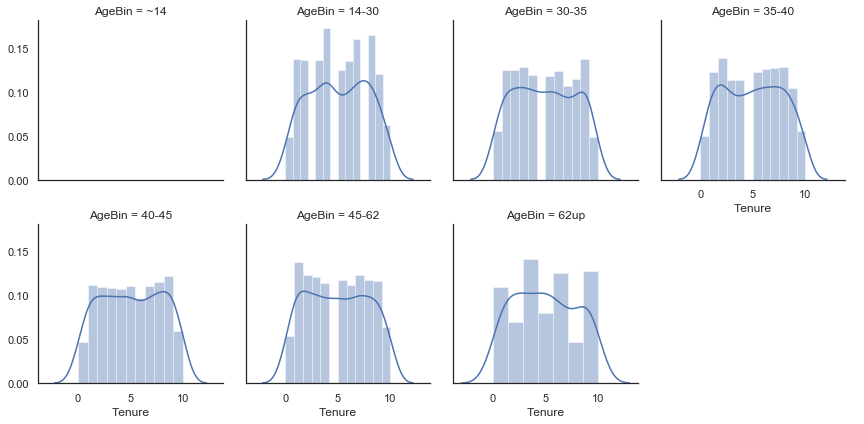

In [74]:
g = sns.FacetGrid(col='AgeBin', 
                  # hue='Claim', 
                  col_order=['~14', '14-30', '30-35', '35-40', '40-45', '45-62', '62up'], 
                  col_wrap=4,
                  data=raw)

g.map(sns.distplot, 'Tenure').add_legend()

In [75]:
anova('Tenure ~ C(AgeBin)', data=raw)

,sum_sq,df,F,PR(>F)
C(AgeBin),26.557390,5.0,0.632602,0.674876
Residual,62921.378076,7494.0,NaN,NaN


## AgeBin  x CreditScore: Distribution Plot, ANOVA

In [76]:
print( raw.CreditScore.describe() )
raw.groupby('AgeBin').CreditScore.agg(['mean', 'std']).reset_index()

count    7500.000000
mean      650.964933
std        96.630512
min       350.000000
25%       584.000000
50%       652.000000
75%       718.000000
max       850.000000
Name: CreditScore, dtype: float64


,AgeBin,mean,std
0,14-30,649.649297,94.817956
1,30-35,653.180984,98.639299
2,35-40,652.321906,97.622045
3,40-45,650.958958,93.912483
4,45-62,646.312628,97.124381
5,62up,659.587859,96.375365


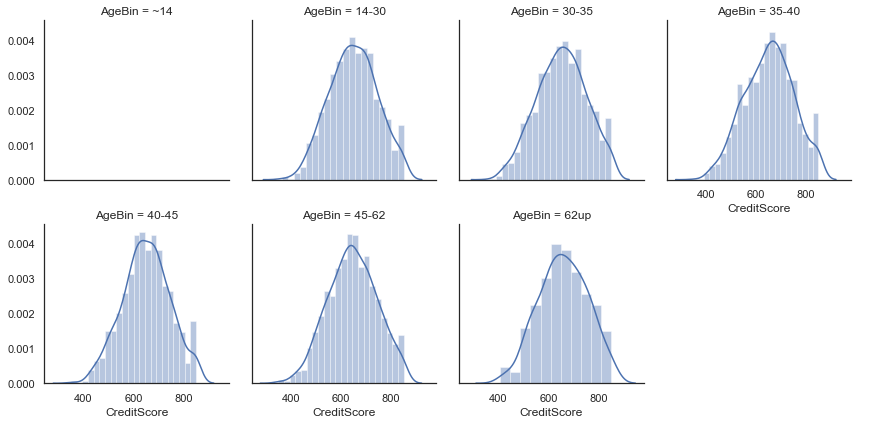

In [77]:
g = sns.FacetGrid(col='AgeBin', 
                  # hue='Claim', 
                  col_order=['~14', '14-30', '30-35', '35-40', '40-45', '45-62', '62up'], 
                  col_wrap=4,
                  data=raw)
g.map(sns.distplot, 'CreditScore').add_legend()

In [78]:
anova('CreditScore ~ C(AgeBin)', data=raw)

,sum_sq,df,F,PR(>F)
C(AgeBin),6.773225e+04,5.0,1.451201,0.202429
Residual,6.995385e+07,7494.0,NaN,NaN


## AgeBin x Balance: Violin Plot, ANOVA

In [79]:
print( raw.Balance.describe() )
raw.groupby('AgeBin').Balance.agg(['mean', 'std']).reset_index()

count      7500.000000
mean      76472.102569
std       62527.184934
min           0.000000
25%           0.000000
50%       97055.145000
75%      127811.165000
max      250898.090000
Name: Balance, dtype: float64


,AgeBin,mean,std
0,14-30,73631.094938,63634.560391
1,30-35,75102.902715,62236.736460
2,35-40,75571.150976,62927.151165
3,40-45,78022.361223,62779.423475
4,45-62,80001.976109,61415.669797
5,62up,76273.710383,61128.767578


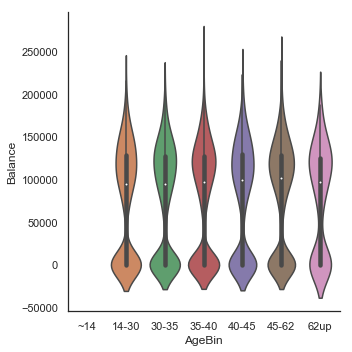

In [80]:
sns.catplot(x='AgeBin', 
            y='Balance', 
            # hue='Claim', 
            order=['~14', '14-30', '30-35', '35-40', '40-45', '45-62', '62up'],
            data=raw,
            split=True, kind='violin')

In [81]:
anova("Balance ~ C(AgeBin)", data=raw)

,sum_sq,df,F,PR(>F)
C(AgeBin),3.532533e+10,5.0,1.808058,0.107611
Residual,2.928313e+13,7494.0,NaN,NaN


## (LAB) Geography x CreditScore: Violin Plot, ANOVA

In [82]:
# 解開註解並且修改問號部分
# raw.groupby('???').CreditScore.agg(['mean', 'std']).reset_index()

In [83]:
# 解開註解並且修改問號部分
# sns.catplot(x='Geography', y='???', 
#             # hue='Claim', 
#             kind='violin', split=True, data=raw)

In [84]:
# 解開註解並且修改問號部分
anova("???", data=raw)

PatsyError: error tokenizing input (maybe an unclosed string?)
    ???
    ^

## (LAB) Geography x EstimatedSalary: Box Plot, ANOVA

In [ ]:
# Groupby 'Geography' and compute mean and std


In [ ]:
# Draw boxplot, hue='Geography'


In [ ]:
# ANOVA


## (LAB) Geography x Age(numeric): Violin Plot, ANOVA

In [ ]:
# Groupby 'Geography' and compute mean and std
sns.catplot(x='Geography', y='Age', 
            # hue='Claim', 
            kind='violin', split=True, data=raw)

In [ ]:
# Draw violin plot, hue='Geography'


In [ ]:
# Call "anova" function 去判斷是否顯著(是否有關聯)

### Observations: Violin Plot 與ANOVA 不合
* 看起來似乎沒有顯著行為, 但是ANOVA P-value非常小, 很顯著

## (LAB) Geography x Balance: Distribution Plot, ANOVA

In [ ]:
# Groupby 'Geography' and compute mean and std

In [ ]:
# Draw dist plot, hue='Geography'

In [ ]:
# ANOVA

## Observation

* `Age` 在 `45 ~ 62`歲的時候`Balance`平均稍高
* `Geography`, `Balance` 有顯著關係, `Balance = Germany`的時候平均飆高, 密度分布也不一樣



---

# 多變數分析: Numeric x Numeric

## Age x CreditScore: Regression Plot

In [ ]:
g = sns.lmplot(x='Age', y='CreditScore', 
               # hue='Claim',
               data=raw, height=4, aspect=1.5, markers='x')

## Age x EstimatedSalary: Regression Plot

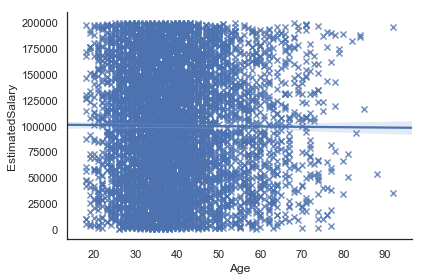

In [85]:
g = sns.lmplot(x='Age', y='EstimatedSalary', 
               # hue='Claim',
               data=raw, height=4, aspect=1.5, markers='x')

## (LAB) CreditScore x EstimatedSalary: Regression Plot

In [86]:
# 解開註解並且填上問號部分
g = sns.lmplot(x='???', y='???', 
               # hue='Claim', 
               data=raw, height=4, aspect=1.5, markers='x')
plt.show()

KeyError: "['???'] not in index"

## (LAB) Balance x CreditScore: Regression Plot

In [87]:
# sns.lmplot

## (LAB) Balance x NumOfProducts: Regression Plot

In [88]:
# sns.lmplot

## Observation

* `Balance` 有大多數的資料都是0
* `Balance`, `NumOfProducts`: 負線性相關

## Correlation: Pearson, Spearman
- Pearson: 變數最好遵從常態分配, 介於 -1 ~ 1之間, 1線性正相關, -1: 線性負相關

$$ \rho = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})} {\sqrt{\sum(x_i - \bar{x}^2 )}\sqrt{\sum(y_i - \bar{y}^2)}} $$

---

- Spearman: 只注重排序關係, numeric, ordinal變數都可以接受, 介於 -1 ~ 1之間, 1線性正相關, -1: 線性負相關

$$ \rho = 1 - \frac{6  \sum d_i^2} {n(n^2 - 1)} $$

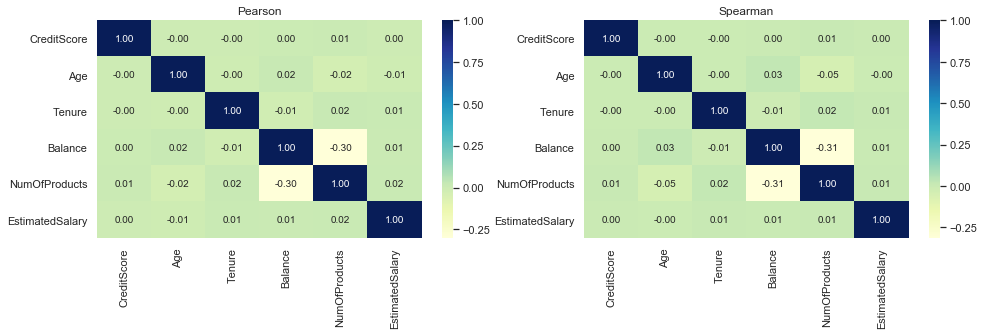

In [89]:
f, axis = plt.subplots(1, 2, figsize=(16, 4))

tmp = raw[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
sns.heatmap(tmp.corr(), annot=True, cmap='YlGnBu', ax=axis[0], fmt='.2f')
sns.heatmap(tmp.corr(method='spearman'), annot=True, cmap='YlGnBu', ax=axis[1], fmt='.2f')
axis[0].set_title('Pearson')
axis[1].set_title('Spearman')
plt.show()

## 類別變數的Correlation Heatmap

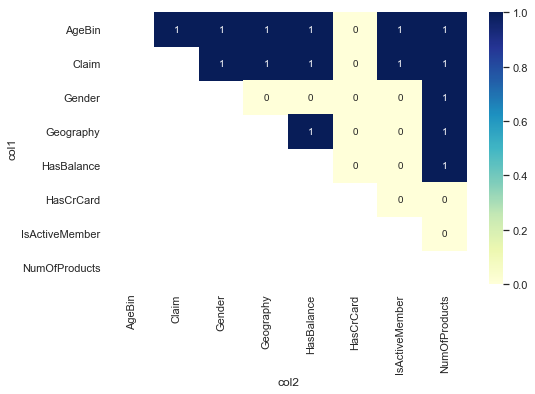

In [90]:
catg_features = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Claim', 'AgeBin', 'HasBalance']

def catg_corr(catg_cols, data):
    corr = []
    for i, x in enumerate(catg_cols):
        corr += [(x, x, 1)]
        for y in catg_cols[i+1:]:
            r = int(chi_square(x, y, data, verbose=False))
            corr += [(x, y, r), (y, x, r)]
            
    corr = pd.DataFrame(data=corr, columns=['col1', 'col2', 'val'])\
             .pivot('col1', 'col2', 'val')
    return corr

corr = catg_corr(catg_features, raw)
plt.figure(figsize=(8, 5))
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(corr, cmap="YlGnBu", mask=mask, annot=True)

# Conclusion

* 顯著變數
    - Numeric, Ordinal
        - Balance
        - Age
        - NumOfProduct
    
    - Categorical
        - Gender
        - AgeBin
        - HasBalance
        - IsActiveMember

        
* 變數相關性
    - `Geography`,  `Balance` 有非線性相關
    - `Geography`, `Gender` 有非線性關係
    - `Geography`, `AgeBin`: 有非線性關係
    - `AgeBin`, `IsActiveMember`: 有非線性關係
    - `AgeBin`, `Gender`: 有非線性關係
    - `Balance`,  `NumOfProduct` 負線性相關
        